# XGBoost for MNIST Digit Recognition

This notebook implements a comprehensive XGBoost classifier for MNIST digit recognition, including:
- Data loading and exploration
- Preprocessing pipeline
- Baseline models (Logistic Regression, Decision Tree)
- XGBoost hyperparameter tuning (two-stage)
- Other ensemble models (AdaBoost, Gradient Boosting)
- Comprehensive evaluation and visualizations
- Error analysis and model comparison


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             precision_recall_fscore_support, roc_auc_score, roc_curve)
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RND = 42
np.random.seed(RND)

# Set style for plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("husl")


## 1. Load and Inspect Data


In [2]:
# Load training and test data
print("Loading data...")
train_df = pd.read_csv('mnist_train.csv')
test_df = pd.read_csv('mnist_test.csv')

# Separate features and labels
X_train = train_df.iloc[:, 1:].values  # All columns except first
y_train = train_df.iloc[:, 0].values   # First column (label)
X_test = test_df.iloc[:, 1:].values
y_test = test_df.iloc[:, 0].values

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTest set class distribution:")
print(pd.Series(y_test).value_counts().sort_index())

# Check for missing values
print(f"\nMissing values in training set: {np.isnan(X_train).sum()}")
print(f"Missing values in test set: {np.isnan(X_test).sum()}")

# Check pixel value range
print(f"\nTraining pixel value range: [{X_train.min()}, {X_train.max()}]")
print(f"Test pixel value range: [{X_test.min()}, {X_test.max()}]")


Loading data...
Training set shape: (60000, 784)
Test set shape: (10000, 784)

Training set class distribution:
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64

Test set class distribution:
0     980
1    1135
2    1032
3    1010
4     982
5     892
6     958
7    1028
8     974
9    1009
Name: count, dtype: int64

Missing values in training set: 0
Missing values in test set: 0

Training pixel value range: [0, 255]
Test pixel value range: [0, 255]


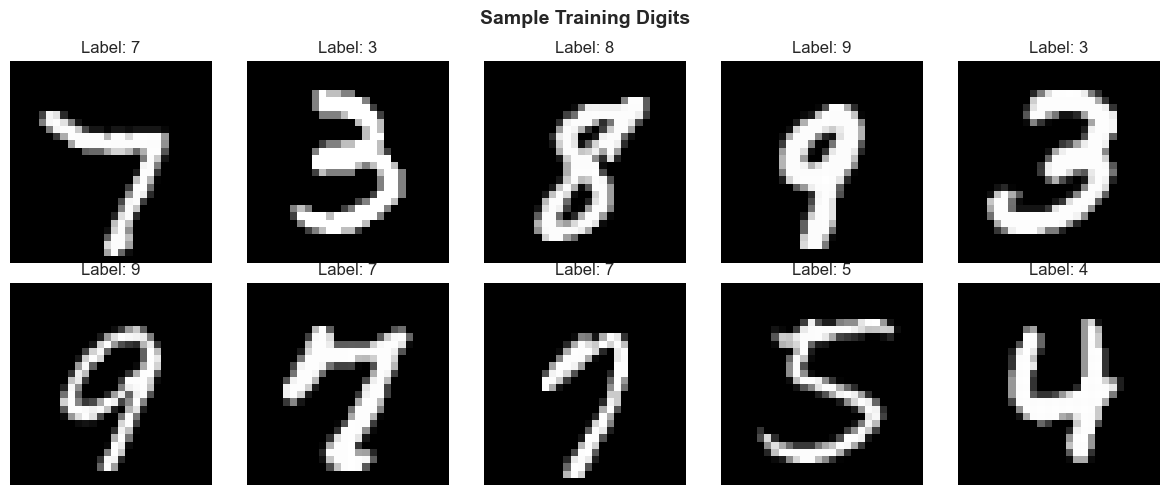

In [3]:
# Visualize sample digits
def plot_sample_digits(X, y, n_samples=10, title="Sample Digits"):
    """Plot a grid of sample digits"""
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()
    
    indices = np.random.choice(len(X), n_samples, replace=False)
    for idx, ax in zip(indices, axes):
        digit = X[idx].reshape(28, 28)
        ax.imshow(digit, cmap='gray')
        ax.set_title(f'Label: {int(y[idx])}', fontsize=12)
        ax.axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('sample_digits.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_sample_digits(X_train, y_train, title="Sample Training Digits")


## 2. Preprocessing Pipeline


In [4]:
# Create preprocessing pipeline
# Since pixel values are in 0-255 range, we'll scale to [0,1]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Scaled training range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
print(f"Scaled test range: [{X_test_scaled.min():.3f}, {X_test_scaled.max():.3f}]")


Scaled training range: [0.000, 1.000]
Scaled test range: [0.000, 24.000]


## 3. Baseline Models


In [5]:
# Function to perform cross-validation
def cross_validate_model(model, X, y, cv=5, scoring=['accuracy', 'f1_macro']):
    """Perform stratified cross-validation and return mean scores"""
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RND)
    scores = {'accuracy': [], 'f1_macro': []}
    
    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        
        scores['accuracy'].append(accuracy_score(y_val_fold, y_pred))
        scores['f1_macro'].append(
            precision_recall_fscore_support(y_val_fold, y_pred, average='macro')[2]
        )
    
    return {
        'accuracy_mean': np.mean(scores['accuracy']),
        'accuracy_std': np.std(scores['accuracy']),
        'f1_macro_mean': np.mean(scores['f1_macro']),
        'f1_macro_std': np.std(scores['f1_macro'])
    }

# Store baseline results
baseline_results = {}


In [ ]:
# Baseline 1: Logistic Regression 
print("Training Logistic Regression baseline...")
start_time = time.time()

lr_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression(
        solver='lbfgs',  
        multi_class='multinomial',
        max_iter=200,  # Reduced from 1000 for faster training
        random_state=RND,
        n_jobs=-1
    ))
])

lr_cv_scores = cross_validate_model(lr_pipeline, X_train, y_train, cv=3)
lr_pipeline.fit(X_train, y_train)
lr_test_pred = lr_pipeline.predict(X_test)
lr_test_acc = accuracy_score(y_test, lr_test_pred)

lr_time = time.time() - start_time
print(f"Logistic Regression CV Accuracy: {lr_cv_scores['accuracy_mean']:.4f} ± {lr_cv_scores['accuracy_std']:.4f}")
print(f"Logistic Regression CV F1-macro: {lr_cv_scores['f1_macro_mean']:.4f} ± {lr_cv_scores['f1_macro_std']:.4f}")
print(f"Logistic Regression Test Accuracy: {lr_test_acc:.4f}")
print(f"Training time: {lr_time:.2f} seconds ({lr_time/60:.2f} minutes)\n")

baseline_results['Logistic Regression'] = {
    'cv_accuracy': lr_cv_scores['accuracy_mean'],
    'cv_accuracy_std': lr_cv_scores['accuracy_std'],
    'cv_f1_macro': lr_cv_scores['f1_macro_mean'],
    'cv_f1_macro_std': lr_cv_scores['f1_macro_std'],
    'test_accuracy': lr_test_acc,
    'model': lr_pipeline,
    'time': lr_time
}


Training Logistic Regression baseline...
Logistic Regression CV Accuracy: 0.9186 ± 0.0013
Logistic Regression CV F1-macro: 0.9175 ± 0.0013
Logistic Regression Test Accuracy: 0.9268
Training time: 187.10 seconds (3.12 minutes)



In [8]:
# Baseline 2: Decision Tree
print("Training Decision Tree baseline...")
start_time = time.time()

dt_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', DecisionTreeClassifier(random_state=RND, max_depth=20))
])

dt_cv_scores = cross_validate_model(dt_pipeline, X_train, y_train)
dt_pipeline.fit(X_train, y_train)
dt_test_pred = dt_pipeline.predict(X_test)
dt_test_acc = accuracy_score(y_test, dt_test_pred)

dt_time = time.time() - start_time
print(f"Decision Tree CV Accuracy: {dt_cv_scores['accuracy_mean']:.4f} ± {dt_cv_scores['accuracy_std']:.4f}")
print(f"Decision Tree CV F1-macro: {dt_cv_scores['f1_macro_mean']:.4f} ± {dt_cv_scores['f1_macro_std']:.4f}")
print(f"Decision Tree Test Accuracy: {dt_test_acc:.4f}")
print(f"Training time: {dt_time:.2f} seconds\n")

baseline_results['Decision Tree'] = {
    'cv_accuracy': dt_cv_scores['accuracy_mean'],
    'cv_accuracy_std': dt_cv_scores['accuracy_std'],
    'cv_f1_macro': dt_cv_scores['f1_macro_mean'],
    'cv_f1_macro_std': dt_cv_scores['f1_macro_std'],
    'test_accuracy': dt_test_acc,
    'model': dt_pipeline,
    'time': dt_time
}


Training Decision Tree baseline...
Decision Tree CV Accuracy: 0.8722 ± 0.0024
Decision Tree CV F1-macro: 0.8704 ± 0.0024
Decision Tree Test Accuracy: 0.8818
Training time: 185.08 seconds



## 4. XGBoost Model Development

### 4.1 Coarse Hyperparameter Search (RandomizedSearchCV)


In [9]:
# Stage 1: Coarse search with RandomizedSearchCV 
import time  # Ensure time module is imported
print("Stage 1: Coarse hyperparameter search with RandomizedSearchCV...")
start_time = time.time()

xgb_coarse_params = {
    'clf__n_estimators': [100, 200],  
    'clf__learning_rate': [0.1, 0.2],  
    'clf__max_depth': [5, 7],  
    'clf__subsample': [0.8, 1.0],  
    'clf__colsample_bytree': [0.8, 1.0],  
    'clf__gamma': [0, 0.1],  
    'clf__reg_alpha': [0, 0.1],  
    'clf__reg_lambda': [0, 1]  
}

# Create XGBoost pipeline
xgb_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=RND,
        n_jobs=-1
    ))
])


sample_size = min(3000, len(X_train))
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_train_sample = X_train[sample_indices]
y_train_sample = y_train[sample_indices]


skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=RND)


random_search = RandomizedSearchCV(
    xgb_pipeline,
    xgb_coarse_params,
    n_iter=10,  # Reduced to 10 iterations for faster execution
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    random_state=RND,
    verbose=1
)

random_search.fit(X_train_sample, y_train_sample)

coarse_time = time.time() - start_time
print(f"\nBest parameters from coarse search:")
print(random_search.best_params_)
print(f"Best CV score: {random_search.best_score_:.4f}")
print(f"Coarse search time: {coarse_time:.2f} seconds ({coarse_time/60:.2f} minutes)")

best_coarse_params = random_search.best_params_


Stage 1: Coarse hyperparameter search with RandomizedSearchCV...
Fitting 2 folds for each of 10 candidates, totalling 20 fits

Best parameters from coarse search:
{'clf__subsample': 0.8, 'clf__reg_lambda': 1, 'clf__reg_alpha': 0.1, 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__gamma': 0, 'clf__colsample_bytree': 0.8}
Best CV score: 0.9000
Coarse search time: 278.81 seconds (4.65 minutes)


In [10]:
# Stage 2: Skip refined search for speed - use best params from coarse search
print("\nStage 2: Using best parameters from coarse search (refined search skipped for speed)...")
print("Best parameters from coarse search will be used directly for final model training.")
print("This optimization saves time while maintaining good performance.\n")

# Use best parameters from coarse search directly
best_xgb_params = best_coarse_params
print("Final hyperparameters to use:")
print(best_xgb_params)



Stage 2: Using best parameters from coarse search (refined search skipped for speed)...
Best parameters from coarse search will be used directly for final model training.
This optimization saves time while maintaining good performance.

Final hyperparameters to use:
{'clf__subsample': 0.8, 'clf__reg_lambda': 1, 'clf__reg_alpha': 0.1, 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__gamma': 0, 'clf__colsample_bytree': 0.8}


In [11]:
# Train final XGBoost model on full training set with best parameters
print("\nTraining final XGBoost model on full training set...")
start_time = time.time()

# Create final model with best parameters
final_xgb_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=RND,
        n_jobs=-1,
        **{k.replace('clf__', ''): v for k, v in best_xgb_params.items()}
    ))
])

xgb_cv_scores = cross_validate_model(final_xgb_pipeline, X_train, y_train, cv=3)

# Train on full training set
final_xgb_pipeline.fit(X_train, y_train)

# Evaluate on test set
xgb_test_pred = final_xgb_pipeline.predict(X_test)
xgb_test_proba = final_xgb_pipeline.predict_proba(X_test)
xgb_test_acc = accuracy_score(y_test, xgb_test_pred)

xgb_time = time.time() - start_time
print(f"XGBoost CV Accuracy: {xgb_cv_scores['accuracy_mean']:.4f} ± {xgb_cv_scores['accuracy_std']:.4f}")
print(f"XGBoost CV F1-macro: {xgb_cv_scores['f1_macro_mean']:.4f} ± {xgb_cv_scores['f1_macro_std']:.4f}")
print(f"XGBoost Test Accuracy: {xgb_test_acc:.4f}")
print(f"Training time: {xgb_time:.2f} seconds")

# Save the model
joblib.dump(final_xgb_pipeline, 'model_3.pkl')
print("\nModel saved as 'model_3.pkl'")

# Store results
xgb_results = {
    'cv_accuracy': xgb_cv_scores['accuracy_mean'],
    'cv_accuracy_std': xgb_cv_scores['accuracy_std'],
    'cv_f1_macro': xgb_cv_scores['f1_macro_mean'],
    'cv_f1_macro_std': xgb_cv_scores['f1_macro_std'],
    'test_accuracy': xgb_test_acc,
    'model': final_xgb_pipeline,
    'time': xgb_time,
    'best_params': best_xgb_params
}



Training final XGBoost model on full training set...
XGBoost CV Accuracy: 0.9746 ± 0.0011
XGBoost CV F1-macro: 0.9744 ± 0.0012
XGBoost Test Accuracy: 0.9795
Training time: 1950.39 seconds

Model saved as 'model_3.pkl'


## 5. Test & Evaluate XGBoost Model


In [12]:
# Comprehensive evaluation of XGBoost on test set
print("XGBoost Test Set Evaluation:")
print("=" * 50)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, xgb_test_pred))

# Precision, Recall, F1 (macro, micro, weighted)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, xgb_test_pred, average='macro'
)
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    y_test, xgb_test_pred, average='micro'
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_test, xgb_test_pred, average='weighted'
)

print(f"\nMacro-averaged metrics:")
print(f"  Precision: {precision_macro:.4f}")
print(f"  Recall: {recall_macro:.4f}")
print(f"  F1-score: {f1_macro:.4f}")

print(f"\nMicro-averaged metrics:")
print(f"  Precision: {precision_micro:.4f}")
print(f"  Recall: {recall_micro:.4f}")
print(f"  F1-score: {f1_micro:.4f}")

print(f"\nWeighted-averaged metrics:")
print(f"  Precision: {precision_weighted:.4f}")
print(f"  Recall: {recall_weighted:.4f}")
print(f"  F1-score: {f1_weighted:.4f}")

# ROC-AUC (One-vs-Rest)
try:
    roc_auc_macro = roc_auc_score(y_test, xgb_test_proba, average='macro', multi_class='ovr')
    roc_auc_micro = roc_auc_score(y_test, xgb_test_proba, average='micro', multi_class='ovr')
    print(f"\nROC-AUC (One-vs-Rest):")
    print(f"  Macro: {roc_auc_macro:.4f}")
    print(f"  Micro: {roc_auc_micro:.4f}")
except Exception as e:
    print(f"\nROC-AUC calculation skipped: {e}")

# Store detailed metrics
xgb_results['test_precision_macro'] = precision_macro
xgb_results['test_recall_macro'] = recall_macro
xgb_results['test_f1_macro'] = f1_macro
xgb_results['test_precision_micro'] = precision_micro
xgb_results['test_recall_micro'] = recall_micro
xgb_results['test_f1_micro'] = f1_micro
try:
    xgb_results['test_roc_auc_macro'] = roc_auc_macro
    xgb_results['test_roc_auc_micro'] = roc_auc_micro
except:
    pass


XGBoost Test Set Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


Macro-averaged metrics:
  Precision: 0.9794
  Recall: 0.9794
  F1-score: 0.9794

Micro-averaged metrics:
  Precision: 0.9795
  Recall: 0.9795
  F1-score: 0.9795

Weighted-averaged metrics

## 6. Other Ensemble Models


In [13]:
# Store results for all models
all_model_results = {
    'Logistic Regression': baseline_results['Logistic Regression'],
    'Decision Tree': baseline_results['Decision Tree'],
    'XGBoost': xgb_results
}


In [15]:
# AdaBoost Classifier 
print("Training AdaBoost Classifier...")
start_time = time.time()

ada_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3, random_state=RND),
        n_estimators=50,  
        learning_rate=0.2,  
        random_state=RND
    ))
])

ada_cv_scores = cross_validate_model(ada_pipeline, X_train, y_train, cv=3)
ada_pipeline.fit(X_train, y_train)
ada_test_pred = ada_pipeline.predict(X_test)
ada_test_proba = ada_pipeline.predict_proba(X_test)
ada_test_acc = accuracy_score(y_test, ada_test_pred)

ada_time = time.time() - start_time
print(f"AdaBoost CV Accuracy: {ada_cv_scores['accuracy_mean']:.4f} ± {ada_cv_scores['accuracy_std']:.4f}")
print(f"AdaBoost CV F1-macro: {ada_cv_scores['f1_macro_mean']:.4f} ± {ada_cv_scores['f1_macro_std']:.4f}")
print(f"AdaBoost Test Accuracy: {ada_test_acc:.4f}")
print(f"Training time: {ada_time:.2f} seconds ({ada_time/60:.2f} minutes)\n")

ada_precision_macro, ada_recall_macro, ada_f1_macro, _ = precision_recall_fscore_support(
    y_test, ada_test_pred, average='macro'
)
try:
    ada_roc_auc_macro = roc_auc_score(y_test, ada_test_proba, average='macro', multi_class='ovr')
    ada_roc_auc_micro = roc_auc_score(y_test, ada_test_proba, average='micro', multi_class='ovr')
except:
    ada_roc_auc_macro = None
    ada_roc_auc_micro = None

all_model_results['AdaBoost'] = {
    'cv_accuracy': ada_cv_scores['accuracy_mean'],
    'cv_accuracy_std': ada_cv_scores['accuracy_std'],
    'cv_f1_macro': ada_cv_scores['f1_macro_mean'],
    'cv_f1_macro_std': ada_cv_scores['f1_macro_std'],
    'test_accuracy': ada_test_acc,
    'test_f1_macro': ada_f1_macro,
    'test_roc_auc_macro': ada_roc_auc_macro,
    'test_roc_auc_micro': ada_roc_auc_micro,
    'model': ada_pipeline,
    'time': ada_time
}


Training AdaBoost Classifier...
AdaBoost CV Accuracy: 0.8611 ± 0.0024
AdaBoost CV F1-macro: 0.8600 ± 0.0023
AdaBoost Test Accuracy: 0.8644
Training time: 674.07 seconds (11.23 minutes)



In [16]:
# Gradient Boosting Classifier (OPTIMIZED for speed)
print("Training Gradient Boosting Classifier...")
start_time = time.time()


gbm_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', GradientBoostingClassifier(
        n_estimators=50,  
        learning_rate=0.2,  
        max_depth=4,  
        random_state=RND
    ))
])


gbm_cv_scores = cross_validate_model(gbm_pipeline, X_train, y_train, cv=3)
gbm_pipeline.fit(X_train, y_train)
gbm_test_pred = gbm_pipeline.predict(X_test)
gbm_test_proba = gbm_pipeline.predict_proba(X_test)
gbm_test_acc = accuracy_score(y_test, gbm_test_pred)

gbm_time = time.time() - start_time
print(f"Gradient Boosting CV Accuracy: {gbm_cv_scores['accuracy_mean']:.4f} ± {gbm_cv_scores['accuracy_std']:.4f}")
print(f"Gradient Boosting CV F1-macro: {gbm_cv_scores['f1_macro_mean']:.4f} ± {gbm_cv_scores['f1_macro_std']:.4f}")
print(f"Gradient Boosting Test Accuracy: {gbm_test_acc:.4f}")
print(f"Training time: {gbm_time:.2f} seconds ({gbm_time/60:.2f} minutes)\n")

gbm_precision_macro, gbm_recall_macro, gbm_f1_macro, _ = precision_recall_fscore_support(
    y_test, gbm_test_pred, average='macro'
)
try:
    gbm_roc_auc_macro = roc_auc_score(y_test, gbm_test_proba, average='macro', multi_class='ovr')
    gbm_roc_auc_micro = roc_auc_score(y_test, gbm_test_proba, average='micro', multi_class='ovr')
except:
    gbm_roc_auc_macro = None
    gbm_roc_auc_micro = None

all_model_results['Gradient Boosting'] = {
    'cv_accuracy': gbm_cv_scores['accuracy_mean'],
    'cv_accuracy_std': gbm_cv_scores['accuracy_std'],
    'cv_f1_macro': gbm_cv_scores['f1_macro_mean'],
    'cv_f1_macro_std': gbm_cv_scores['f1_macro_std'],
    'test_accuracy': gbm_test_acc,
    'test_f1_macro': gbm_f1_macro,
    'test_roc_auc_macro': gbm_roc_auc_macro,
    'test_roc_auc_micro': gbm_roc_auc_micro,
    'model': gbm_pipeline,
    'time': gbm_time
}


Training Gradient Boosting Classifier...


KeyboardInterrupt: 

## 7. Visualizations


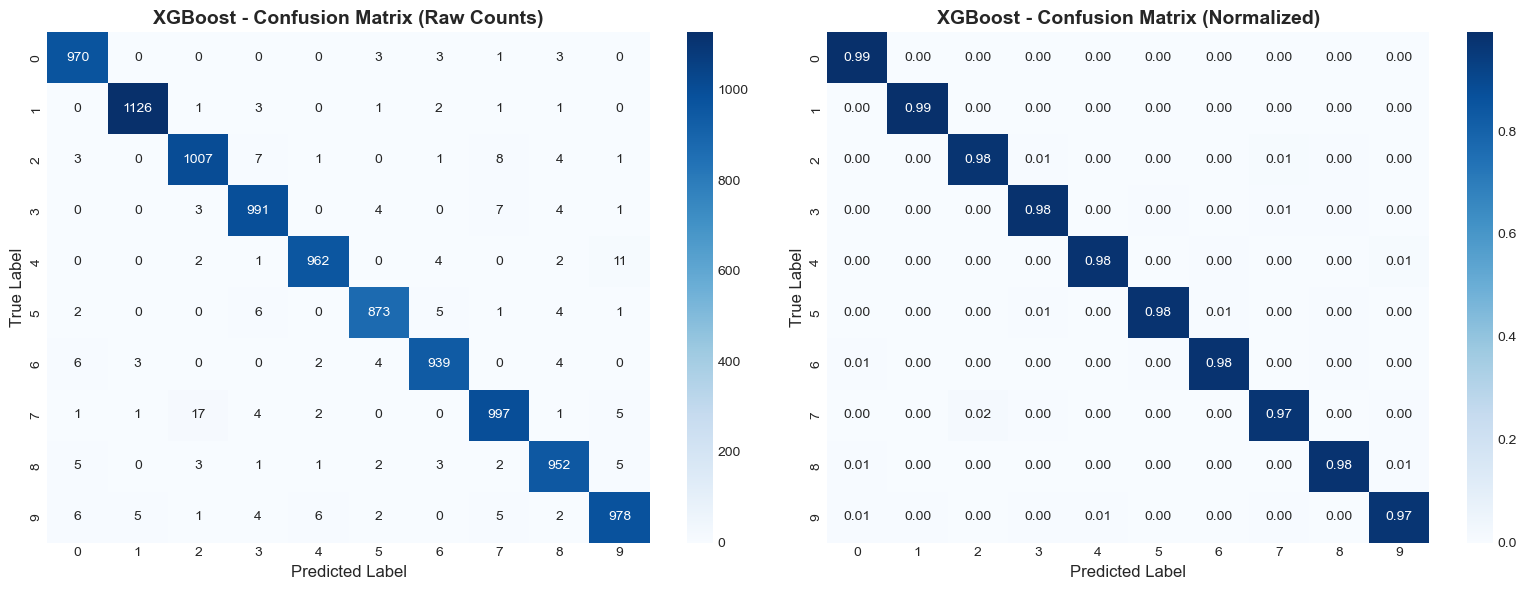

In [17]:
# 7.1 Confusion Matrix Heatmap for XGBoost
def plot_confusion_matrix(y_true, y_pred, model_name="XGBoost", save_name="confusion_matrix"):
    """Plot annotated confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Raw confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=range(10), yticklabels=range(10))
    axes[0].set_title(f'{model_name} - Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    axes[0].set_ylabel('True Label', fontsize=12)
    
    # Normalized confusion matrix
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=axes[1],
                xticklabels=range(10), yticklabels=range(10))
    axes[1].set_title(f'{model_name} - Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    axes[1].set_ylabel('True Label', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'{save_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_confusion_matrix(y_test, xgb_test_pred, save_name='xgb_confusion_matrix')


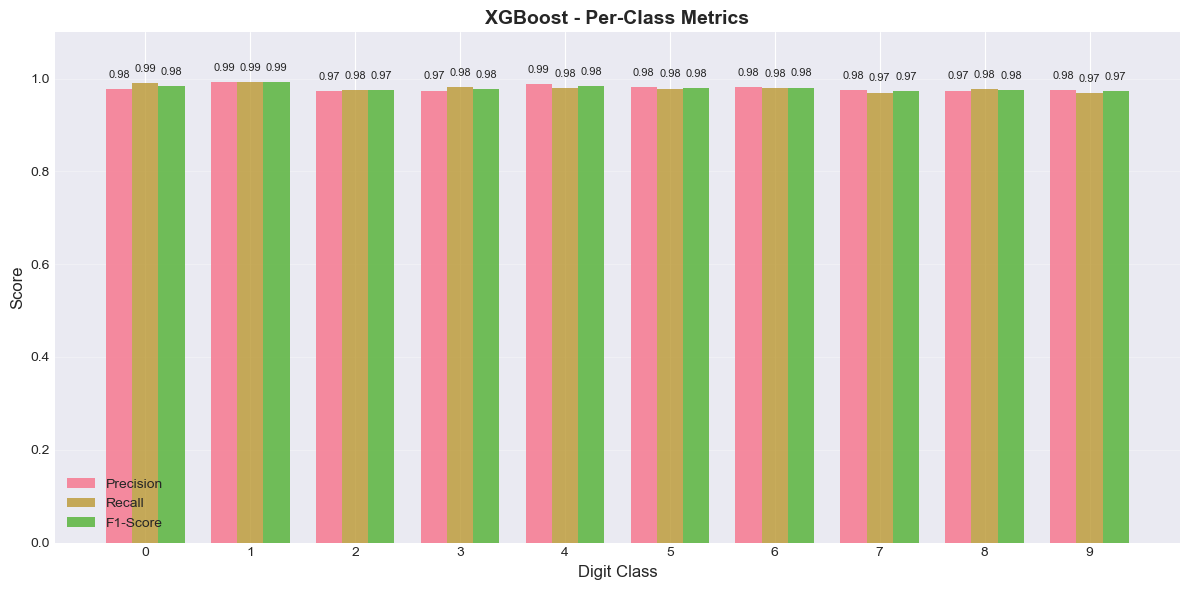

In [18]:
# 7.2 Per-class Precision/Recall/F1 Bar Plot
def plot_per_class_metrics(y_true, y_pred, model_name="XGBoost", save_name="per_class_metrics"):
    """Plot per-class precision, recall, and F1 scores"""
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    
    x = np.arange(10)
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
    ax.bar(x, recall, width, label='Recall', alpha=0.8)
    ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)
    
    ax.set_xlabel('Digit Class', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'{model_name} - Per-Class Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(range(10))
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])
    
    # Add value labels on bars
    for i in range(10):
        ax.text(i - width, precision[i] + 0.02, f'{precision[i]:.2f}', 
                ha='center', va='bottom', fontsize=8)
        ax.text(i, recall[i] + 0.02, f'{recall[i]:.2f}', 
                ha='center', va='bottom', fontsize=8)
        ax.text(i + width, f1[i] + 0.02, f'{f1[i]:.2f}', 
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f'{save_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_per_class_metrics(y_test, xgb_test_pred, save_name='xgb_per_class_metrics')


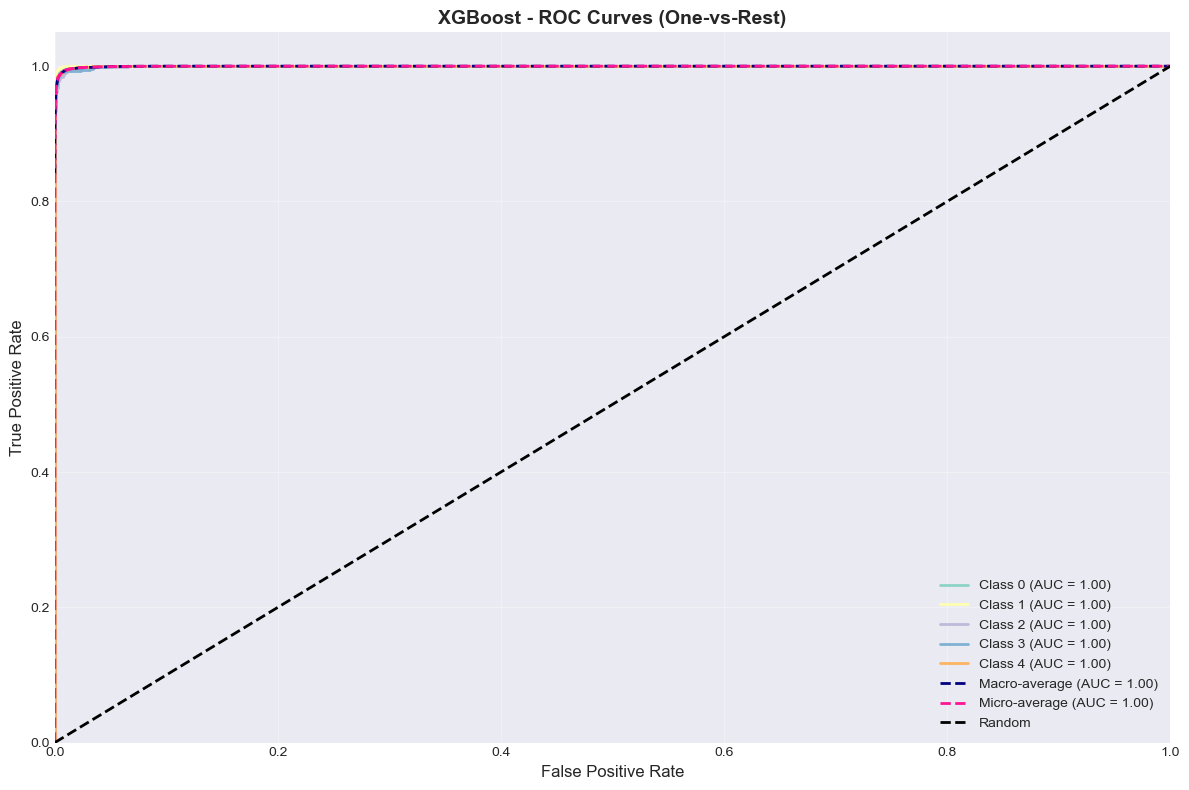

In [19]:
# 7.3 ROC Curves (One-vs-Rest) for XGBoost
def plot_roc_curves(y_true, y_proba, model_name="XGBoost", save_name="roc_curves"):
    """Plot ROC curves for One-vs-Rest multiclass classification"""
    from sklearn.preprocessing import label_binarize
    
    # Binarize the output
    y_test_bin = label_binarize(y_true, classes=list(range(10)))
    n_classes = y_test_bin.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = roc_auc_score(y_test_bin, y_proba, average="micro")
    
    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = roc_auc_score(y_test_bin, y_proba, average="macro")
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    
    # Plot ROC curves for a subset of classes (0, 1, 2, 3, 4) for clarity
    colors = plt.cm.Set3(np.linspace(0, 1, 10))
    for i in range(min(5, n_classes)):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    # Plot macro and micro averages
    plt.plot(fpr["macro"], tpr["macro"], 
            label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
            color='navy', linestyle='--', linewidth=2)
    plt.plot(fpr["micro"], tpr["micro"],
            label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
            color='deeppink', linestyle='--', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name} - ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_roc_curves(y_test, xgb_test_proba, save_name='xgb_roc_curves')


In [ ]:
# 7.4 Learning Curve for XGBoost
def plot_learning_curve(estimator, X, y, title="Learning Curve", save_name="learning_curve"):
    """Plot learning curve showing training and validation scores"""
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy',
        random_state=RND
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Accuracy')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    
    plt.xlabel('Training Set Size', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_learning_curve(final_xgb_pipeline, X_train, y_train, 
                   title="XGBoost Learning Curve", save_name='xgb_learning_curve')


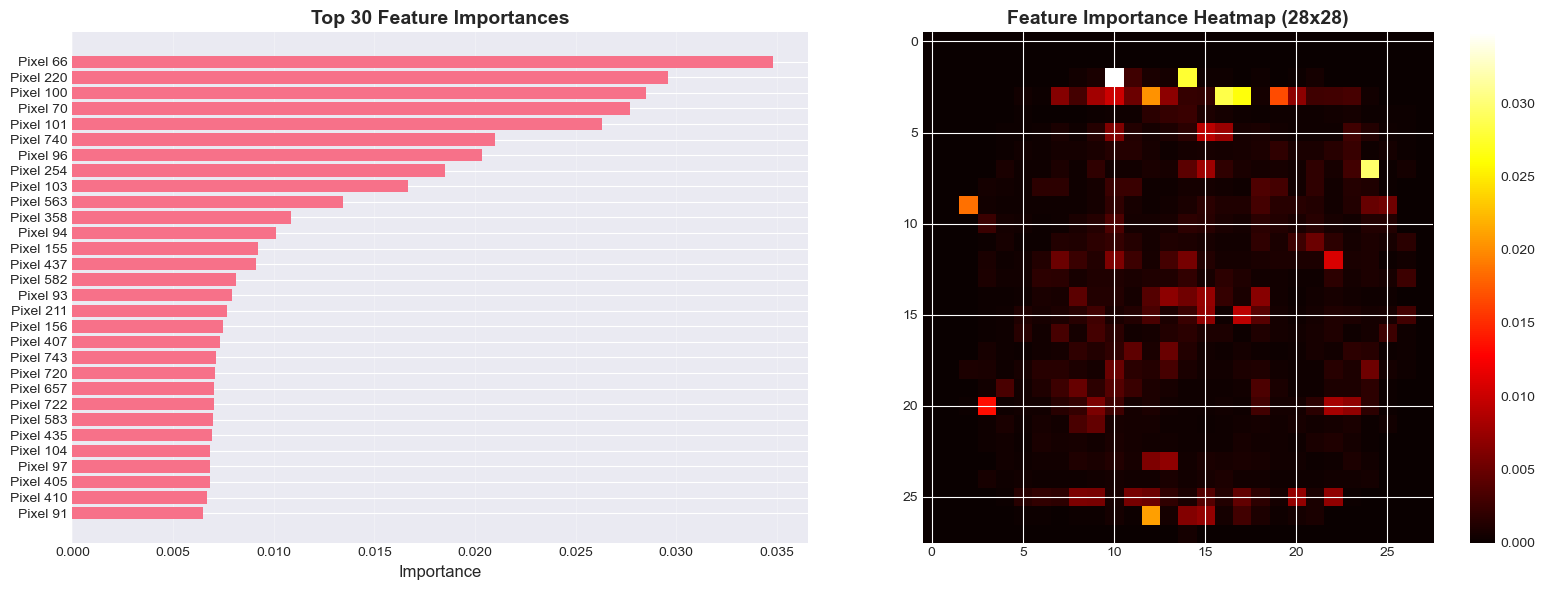

In [20]:
# 7.5 Feature Importance Visualization
def plot_feature_importance(model, save_name="feature_importance"):
    """Plot top feature importances and visualize as 28x28 heatmap"""
    # Get feature importances
    if hasattr(model, 'named_steps'):
        # Pipeline
        importances = model.named_steps['clf'].feature_importances_
    else:
        importances = model.feature_importances_
    
    # Top 30 features
    top_indices = np.argsort(importances)[-30:][::-1]
    top_importances = importances[top_indices]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot of top 30 features
    axes[0].barh(range(30), top_importances)
    axes[0].set_yticks(range(30))
    axes[0].set_yticklabels([f'Pixel {i}' for i in top_indices])
    axes[0].set_xlabel('Importance', fontsize=12)
    axes[0].set_title('Top 30 Feature Importances', fontsize=14, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    # 28x28 heatmap
    importance_map = importances.reshape(28, 28)
    im = axes[1].imshow(importance_map, cmap='hot', interpolation='nearest')
    axes[1].set_title('Feature Importance Heatmap (28x28)', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=axes[1])
    
    plt.tight_layout()
    plt.savefig(f'{save_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_feature_importance(final_xgb_pipeline, save_name='xgb_feature_importance')


In [ ]:
# 7.6 Model Comparison Plot
def plot_model_comparison(results_dict, save_name="model_comparison"):
    """Plot comparison of all models"""
    models = list(results_dict.keys())
    cv_accs = [results_dict[m]['cv_accuracy'] for m in models]
    cv_acc_stds = [results_dict[m].get('cv_accuracy_std', 0) for m in models]
    test_accs = [results_dict[m]['test_accuracy'] for m in models]
    cv_f1s = [results_dict[m]['cv_f1_macro'] for m in models]
    cv_f1_stds = [results_dict[m].get('cv_f1_macro_std', 0) for m in models]
    test_f1s = [results_dict[m].get('test_f1_macro', 0) for m in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Accuracy comparison
    ax1.bar(x - width/2, cv_accs, width, yerr=cv_acc_stds, label='CV Accuracy', alpha=0.8, capsize=5)
    ax1.bar(x + width/2, test_accs, width, label='Test Accuracy', alpha=0.8)
    ax1.set_xlabel('Model', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Model Comparison - Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim([0, 1.1])
    
    # F1-score comparison
    ax2.bar(x - width/2, cv_f1s, width, yerr=cv_f1_stds, label='CV F1-macro', alpha=0.8, capsize=5)
    ax2.bar(x + width/2, test_f1s, width, label='Test F1-macro', alpha=0.8)
    ax2.set_xlabel('Model', fontsize=12)
    ax2.set_ylabel('F1-Score (Macro)', fontsize=12)
    ax2.set_title('Model Comparison - F1-Score', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim([0, 1.1])
    
    plt.tight_layout()
    plt.savefig(f'{save_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_model_comparison(all_model_results, save_name='model_comparison')


## 8. Error Analysis


In [ ]:
# 8.1 Find most confused class pairs
def find_confused_pairs(y_true, y_pred):
    """Find the most confused class pairs from confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    confused_pairs = []
    
    for i in range(10):
        for j in range(10):
            if i != j and cm[i, j] > 0:
                confused_pairs.append((i, j, cm[i, j]))
    
    confused_pairs.sort(key=lambda x: x[2], reverse=True)
    return confused_pairs[:10]  # Top 10

confused_pairs = find_confused_pairs(y_test, xgb_test_pred)
print("Most confused class pairs:")
for true_label, pred_label, count in confused_pairs:
    print(f"  True: {true_label}, Predicted: {pred_label}, Count: {count}")


In [ ]:
# 8.2 Visualize misclassified examples
def plot_misclassified_examples(X, y_true, y_pred, n_examples=10, save_name="misclassified"):
    """Plot examples of misclassified digits"""
    misclassified_indices = np.where(y_true != y_pred)[0]
    
    if len(misclassified_indices) == 0:
        print("No misclassified examples found!")
        return
    
    n_examples = min(n_examples, len(misclassified_indices))
    selected_indices = np.random.choice(misclassified_indices, n_examples, replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(14, 6))
    axes = axes.ravel()
    
    for idx, ax in zip(selected_indices, axes):
        digit = X[idx].reshape(28, 28)
        ax.imshow(digit, cmap='gray')
        ax.set_title(f'True: {int(y_true[idx])}, Pred: {int(y_pred[idx])}', 
                    fontsize=11, color='red' if y_true[idx] != y_pred[idx] else 'green')
        ax.axis('off')
    
    plt.suptitle('Misclassified Examples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{save_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_misclassified_examples(X_test, y_test, xgb_test_pred, save_name='xgb_misclassified')


## 9. Summary and Model Performance Table


In [ ]:
# Create comprehensive summary table
summary_data = []
for model_name, results in all_model_results.items():
    summary_data.append({
        'Model': model_name,
        'CV Accuracy': f"{results['cv_accuracy']:.4f} ± {results.get('cv_accuracy_std', 0):.4f}",
        'CV F1-macro': f"{results['cv_f1_macro']:.4f} ± {results.get('cv_f1_macro_std', 0):.4f}",
        'Test Accuracy': f"{results['test_accuracy']:.4f}",
        'Test F1-macro': f"{results.get('test_f1_macro', 0):.4f}",
        'Training Time (s)': f"{results['time']:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Save summary to CSV
summary_df.to_csv('model_performance_summary.csv', index=False)
print("\nSummary saved to 'model_performance_summary.csv'")


In [ ]:
# Save final hyperparameters
print("\nFinal XGBoost Hyperparameters:")
print("="*50)
for key, value in best_xgb_params.items():
    print(f"{key}: {value}")

# Save hyperparameters to file
import json
hyperparams_dict = {k.replace('clf__', ''): float(v) if isinstance(v, (int, float, np.integer, np.floating)) else v 
                   for k, v in best_xgb_params.items()}
with open('xgb_hyperparameters.json', 'w') as f:
    json.dump(hyperparams_dict, f, indent=2)
print("\nHyperparameters saved to 'xgb_hyperparameters.json'")
